## Pytorchのnnモジュール

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

### nn.Linear

In [2]:
linear = nn.Linear(64, 30)
# weightとbiasの二つのtensorがparameter
list(linear.parameters())

[Parameter containing:
 tensor([[-0.0445,  0.0273,  0.0644,  ..., -0.0004,  0.0982, -0.0988],
         [-0.0505, -0.0322, -0.0073,  ..., -0.0187,  0.0680, -0.0556],
         [-0.0376, -0.0396, -0.0291,  ...,  0.0521, -0.1179,  0.0771],
         ...,
         [ 0.0637,  0.0988,  0.1097,  ..., -0.0255, -0.0306, -0.0304],
         [ 0.0380,  0.0816, -0.0582,  ..., -0.0325, -0.0317, -0.0513],
         [ 0.0148, -0.0768,  0.0188,  ..., -0.1154, -0.0139,  0.1208]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.0092,  0.0294,  0.0859, -0.0046, -0.0866, -0.0182, -0.0050,  0.0097,
          0.0126, -0.0632,  0.0738,  0.0108,  0.1179, -0.0548,  0.1244, -0.1035,
         -0.0980,  0.0472, -0.0942, -0.0102, -0.0765, -0.1038, -0.0761, -0.1179,
          0.0798,  0.0589, -0.0605, -0.0856, -0.0483,  0.0448],
        requires_grad=True)]

In [3]:
# weightは出力x入力であることに注意．Z = X@W.T + bになっている
print(linear.weight.shape)
print(linear.bias.shape)

torch.Size([30, 64])
torch.Size([30])


In [4]:
linear.bias.shape

torch.Size([30])

In [5]:
# 順伝搬
X = torch.randn((5, 64))
Z = linear(X)
Z.shape

torch.Size([5, 30])

### MLP実装

In [6]:
# 1. nn.クラスとF.関数を組み合わせたケース
class MLP(nn.Module):
    def __init__(self, num_in, num_hidden, num_out):
        super().__init__()
        self.l1 = nn.Linear(num_in, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_out)

    def forward(self, x):
        # z1 = self.l1(x)
        # a1 = F.relu(z1)
        # z2 = self.l2(a1)
        x = self.l2(F.relu(self.l1(x)))
        return x

In [7]:
# 順伝搬テスト
model = MLP(64, 30, 10)
X = torch.randn(5, 64)
Z = model(X)
Z.shape

torch.Size([5, 10])

In [8]:
# 2. nn.クラスのみで構成するケース
class MLP(nn.Module):
    def __init__(self, num_in, num_hidden, num_out):
        super().__init__()
        self.l1 = nn.Linear(num_in, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_out)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.l2(self.relu(self.l1(x)))
        return x

In [9]:
# 順伝搬テスト
model = MLP(64, 30, 10)
X = torch.randn(5, 64)
Z = model(X)
Z.shape

torch.Size([5, 10])

In [10]:
# 3. nn.Sequentialを使ったケース
num_in = 64
num_hidden = 30
num_out = 10

model = nn.Sequential(
    nn.Linear(num_in, num_hidden),
    nn.ReLU(),
    nn.Linear(num_hidden, num_out)
)

In [11]:
# 順伝搬テスト
Z = model(X)
Z.shape

torch.Size([5, 10])

### MLP学習

In [12]:
class MLP(nn.Module):
    def __init__(self, num_in, num_hidden, num_out):
        super().__init__()
        self.l1 = nn.Linear(num_in, num_hidden)
        self.l2 = nn.Linear(num_hidden, num_out)

    def forward(self, x):
        # z1 = self.l1(x)
        # a1 = F.relu(z1)
        # z2 = self.l2(a1)
        x = self.l2(F.relu(self.l1(x)))
        return x

## Refactoring後の学習ループ(OptimizerやDataset, Dataloaderは後ほどRefactoring)
# ===データの準備====
dataset = datasets.load_digits()
data = dataset['data']
target = dataset['target']
images = dataset['images']
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)
X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train = (X_train - X_train_mean) / X_train_std
X_val = (X_val - X_train_mean) / X_train_std
X_train = torch.tensor(X_train.reshape(-1, 64), dtype=torch.float32)
X_val = torch.tensor(X_val.reshape(-1, 64), dtype=torch.float32)
y_train = torch.tensor(y_train) 
y_val = torch.tensor(y_val) 
batch_size = 30
num_batches = np.ceil(len(y_train)/batch_size).astype(int)
model = MLP(64, 30, 10)
learning_rate = 0.03

# ログ
train_losses = []
val_losses = []
val_accuracies = []
for epoch in range(100):
    # エポック毎にデータをシャッフル
    shuffled_indices = np.random.permutation(len(y_train))
    running_loss = 0.0
    
    for i in range(num_batches):
        
        # mini batch作成
        start = i * batch_size
        end = start + batch_size

        batch_indices = shuffled_indices[start:end]
        y = y_train[batch_indices] # batch_size x 10
        
        X = X_train[batch_indices] # batch_size x 64
        # 順伝播と逆伝播の計算
        preds = model(X)
        loss = F.cross_entropy(preds, y)
        loss.backward()
        running_loss += loss.item()

        # パラメータ更新
        with torch.no_grad():
            for param in model.parameters():
                param -= learning_rate * param.grad

        model.zero_grad()
        

    # validation
    with torch.no_grad():
        preds_val = model(X_val)
        val_loss = F.cross_entropy(preds_val, y_val)
        val_accuracy = torch.sum(torch.argmax(preds_val, dim=-1) == y_val) / y_val.shape[0]

    train_losses.append(running_loss/num_batches)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_accuracy)
    print(f'epoch: {epoch}: train error: {running_loss/num_batches}, validation error: {val_loss.item()}, validation accuracy: {val_accuracy}')

epoch: 0: train error: 2.154320647319158, validation error: 1.7531390190124512, validation accuracy: 0.42222222685813904
epoch: 1: train error: 1.6368044565121334, validation error: 0.9298788905143738, validation accuracy: 0.7194444537162781
epoch: 2: train error: 1.0713035389780998, validation error: 0.592543363571167, validation accuracy: 0.8583333492279053
epoch: 3: train error: 0.7136024795472622, validation error: 0.5384640693664551, validation accuracy: 0.8666666746139526
epoch: 4: train error: 0.5207117665559053, validation error: 0.4854482412338257, validation accuracy: 0.8916666507720947
epoch: 5: train error: 0.41144252351174754, validation error: 0.4479805827140808, validation accuracy: 0.9138888716697693
epoch: 6: train error: 0.34291895137478906, validation error: 0.40326207876205444, validation accuracy: 0.9194444417953491
epoch: 7: train error: 0.29385997354984283, validation error: 0.36855587363243103, validation accuracy: 0.9333333373069763
epoch: 8: train error: 0.258

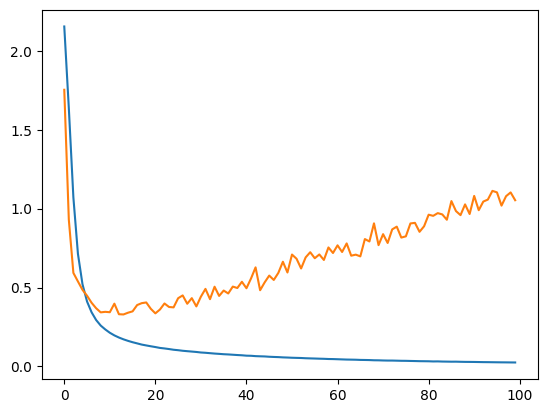

In [13]:
plt.plot(train_losses)
plt.plot(val_losses)

### パラメータのイテレーション

In [14]:
model

MLP(
  (l1): Linear(in_features=64, out_features=30, bias=True)
  (l2): Linear(in_features=30, out_features=10, bias=True)
)

In [15]:
for param in model.parameters():
    print(param.shape)

torch.Size([30, 64])
torch.Size([30])
torch.Size([10, 30])
torch.Size([10])


In [16]:
for name, param in model.named_parameters():
    print(name, param.shape)

l1.weight torch.Size([30, 64])
l1.bias torch.Size([30])
l2.weight torch.Size([10, 30])
l2.bias torch.Size([10])


### コンポーネントのイテレーション

In [17]:
for module in model.children():
    print(module)

Linear(in_features=64, out_features=30, bias=True)
Linear(in_features=30, out_features=10, bias=True)


In [18]:
for name, module in model.named_children():
    print(name, module)

l1 Linear(in_features=64, out_features=30, bias=True)
l2 Linear(in_features=30, out_features=10, bias=True)


In [19]:
# 最初に自分自身を返す
for module in model.modules():
    print(module)

MLP(
  (l1): Linear(in_features=64, out_features=30, bias=True)
  (l2): Linear(in_features=30, out_features=10, bias=True)
)
Linear(in_features=64, out_features=30, bias=True)
Linear(in_features=30, out_features=10, bias=True)


In [20]:
# 自分自身には名前がついていない
for name, module in model.named_modules():
    print(name)


l1
l2
